In [132]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [139]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [140]:
# Load the dataset
root_dir = 'archive /data'
all_data = datasets.ImageFolder(root=root_dir, transform=transform)

In [135]:
# Split the data into training, validation, and test sets
train_size = int(0.6 * len(all_data))
val_size = int(0.2 * len(all_data))
test_size = len(all_data) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(all_data, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

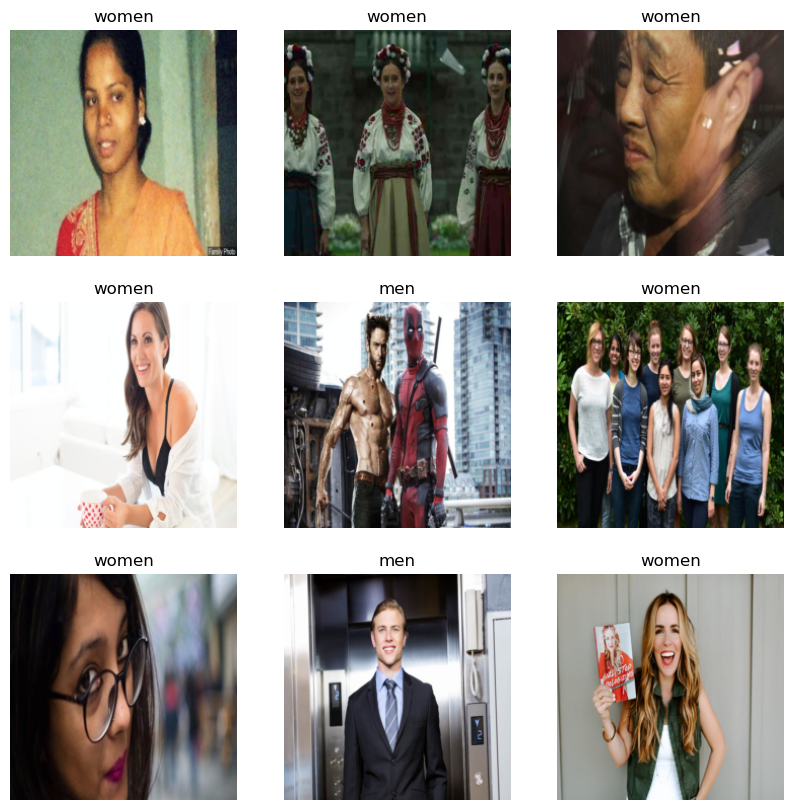

In [141]:
# Visualize some images from the training set
class_names = all_data.classes

# Shuffle indices
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)

plt.figure(figsize=(10, 10))
for i in range(9):
    img, label = train_dataset[indices[i]]
    img = img.permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis("off")
plt.show()

In [143]:
# Define the model
class GenderClassificationModel(nn.Module):
    def __init__(self):
        super(GenderClassificationModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False  # Freeze the layers
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)
    
    def forward(self, x):
        return self.model(x)

model = GenderClassificationModel()

In [144]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.fc.parameters(), lr=0.001)  # Only update the fully connected layer

# Variables to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    model.train()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), 'gender_classification_model.pth')


Epoch [1/10], Step [1/63], Loss: 0.7030
Epoch [1/10], Step [11/63], Loss: 0.5769
Epoch [1/10], Step [21/63], Loss: 0.5287
Epoch [1/10], Step [31/63], Loss: 0.3472
Epoch [1/10], Step [41/63], Loss: 0.4540
Epoch [1/10], Step [51/63], Loss: 0.2396
Epoch [1/10], Step [61/63], Loss: 0.4048
Epoch [1/10], Train Loss: 0.4369, Train Accuracy: 79.19%, Val Loss: 0.4450, Val Accuracy: 78.37%
Epoch [2/10], Step [1/63], Loss: 0.4078
Epoch [2/10], Step [11/63], Loss: 0.2905
Epoch [2/10], Step [21/63], Loss: 0.3223
Epoch [2/10], Step [31/63], Loss: 0.2432
Epoch [2/10], Step [41/63], Loss: 0.4242
Epoch [2/10], Step [51/63], Loss: 0.4703
Epoch [2/10], Step [61/63], Loss: 0.4000
Epoch [2/10], Train Loss: 0.2992, Train Accuracy: 87.81%, Val Loss: 0.2643, Val Accuracy: 90.02%
Epoch [3/10], Step [1/63], Loss: 0.1996
Epoch [3/10], Step [11/63], Loss: 0.1811
Epoch [3/10], Step [21/63], Loss: 0.4068
Epoch [3/10], Step [31/63], Loss: 0.2320
Epoch [3/10], Step [41/63], Loss: 0.2758
Epoch [3/10], Step [51/63], Lo

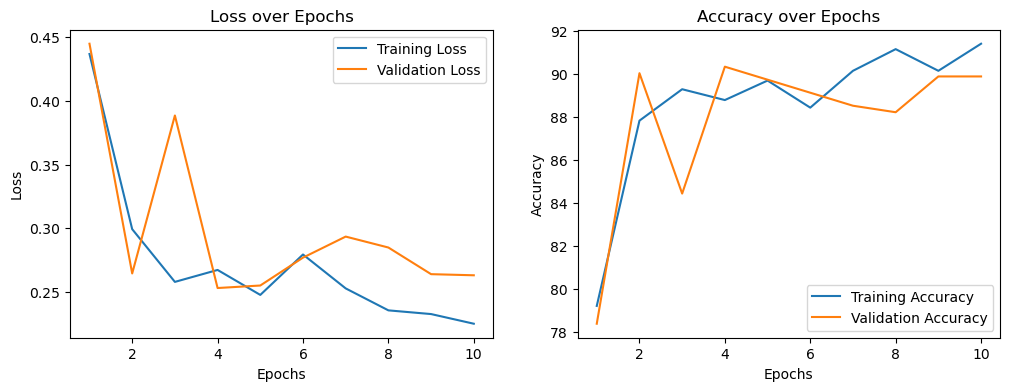

In [145]:
# Plotting the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


In [147]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0

print(f'Number of iterations (batches) in test set: {len(test_loader)}')

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print the information for each iteration
        iteration_loss = loss.item()
        iteration_accuracy = 100 * correct / total
        print(f'Iteration {i+1}/{len(test_loader)}, Loss: {iteration_loss:.4f}, Cumulative Accuracy: {iteration_accuracy:.2f}%')

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')


Number of iterations (batches) in test set: 21
Iteration 1/21, Loss: 0.0807, Cumulative Accuracy: 100.00%
Iteration 2/21, Loss: 0.3771, Cumulative Accuracy: 90.62%
Iteration 3/21, Loss: 0.3129, Cumulative Accuracy: 88.54%
Iteration 4/21, Loss: 0.2419, Cumulative Accuracy: 89.06%
Iteration 5/21, Loss: 0.1049, Cumulative Accuracy: 90.62%
Iteration 6/21, Loss: 0.0712, Cumulative Accuracy: 91.67%
Iteration 7/21, Loss: 0.1813, Cumulative Accuracy: 91.52%
Iteration 8/21, Loss: 0.2873, Cumulative Accuracy: 91.02%
Iteration 9/21, Loss: 0.3862, Cumulative Accuracy: 89.93%
Iteration 10/21, Loss: 0.3581, Cumulative Accuracy: 89.38%
Iteration 11/21, Loss: 0.3925, Cumulative Accuracy: 88.92%
Iteration 12/21, Loss: 0.2619, Cumulative Accuracy: 88.80%
Iteration 13/21, Loss: 0.1457, Cumulative Accuracy: 89.18%
Iteration 14/21, Loss: 0.2300, Cumulative Accuracy: 89.51%
Iteration 15/21, Loss: 0.1523, Cumulative Accuracy: 89.79%
Iteration 16/21, Loss: 0.5667, Cumulative Accuracy: 89.45%
Iteration 17/21, 